In [4]:
!pip install catboost

In [5]:
!pip install numpy==1.23.5

In [1]:
# =============================================================================
# CatBoost Classification on the Heart Disease Dataset
# =============================================================================
# This script showcases a complete pipeline for predicting heart disease presence:
# 1. Data loading and exploration from a CSV file (heart.csv).
# 2. Data preprocessing (handling missing values, encoding, scaling).
# 3. Training a CatBoostClassifier for binary classification.
# 4. Evaluation with classification report, confusion matrix, and ROC curve.
# 5. Advanced Visualizations including:
# Confusion Matrix (with "flare" colormap)
# Feature Importance using CatBoost's built-in method
# Partial Dependence Plot to examine how a feature affects predictions
# A custom pairplot to visualize data distributions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import PartialDependenceDisplay
from catboost import CatBoostClassifier

In [2]:
# -----------------------------------------------------------------------------
# Set a new visualization style: "bmh" with custom palette.
# -----------------------------------------------------------------------------
plt.style.use("bmh")
sns.set_theme(style="ticks", palette="pastel")

In [7]:
# -----------------------------------------------------------------------------
# Data Loading and Exploration
# -----------------------------------------------------------------------------
df = pd.read_csv("/content/heart.csv")

In [8]:
## columns

# ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang',
#  'oldpeak','slope','ca','thal','target']
# Where 'target' = 1 indicates presence of heart disease, 0 indicates absence.

In [9]:
# -----------------------------------------------------------------------------
# Data Preprocessing
# -----------------------------------------------------------------------------
# Check for missing values
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [11]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

In [12]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

In [13]:
# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

# For simplicity, let's encode any categorical columns if they exist
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))


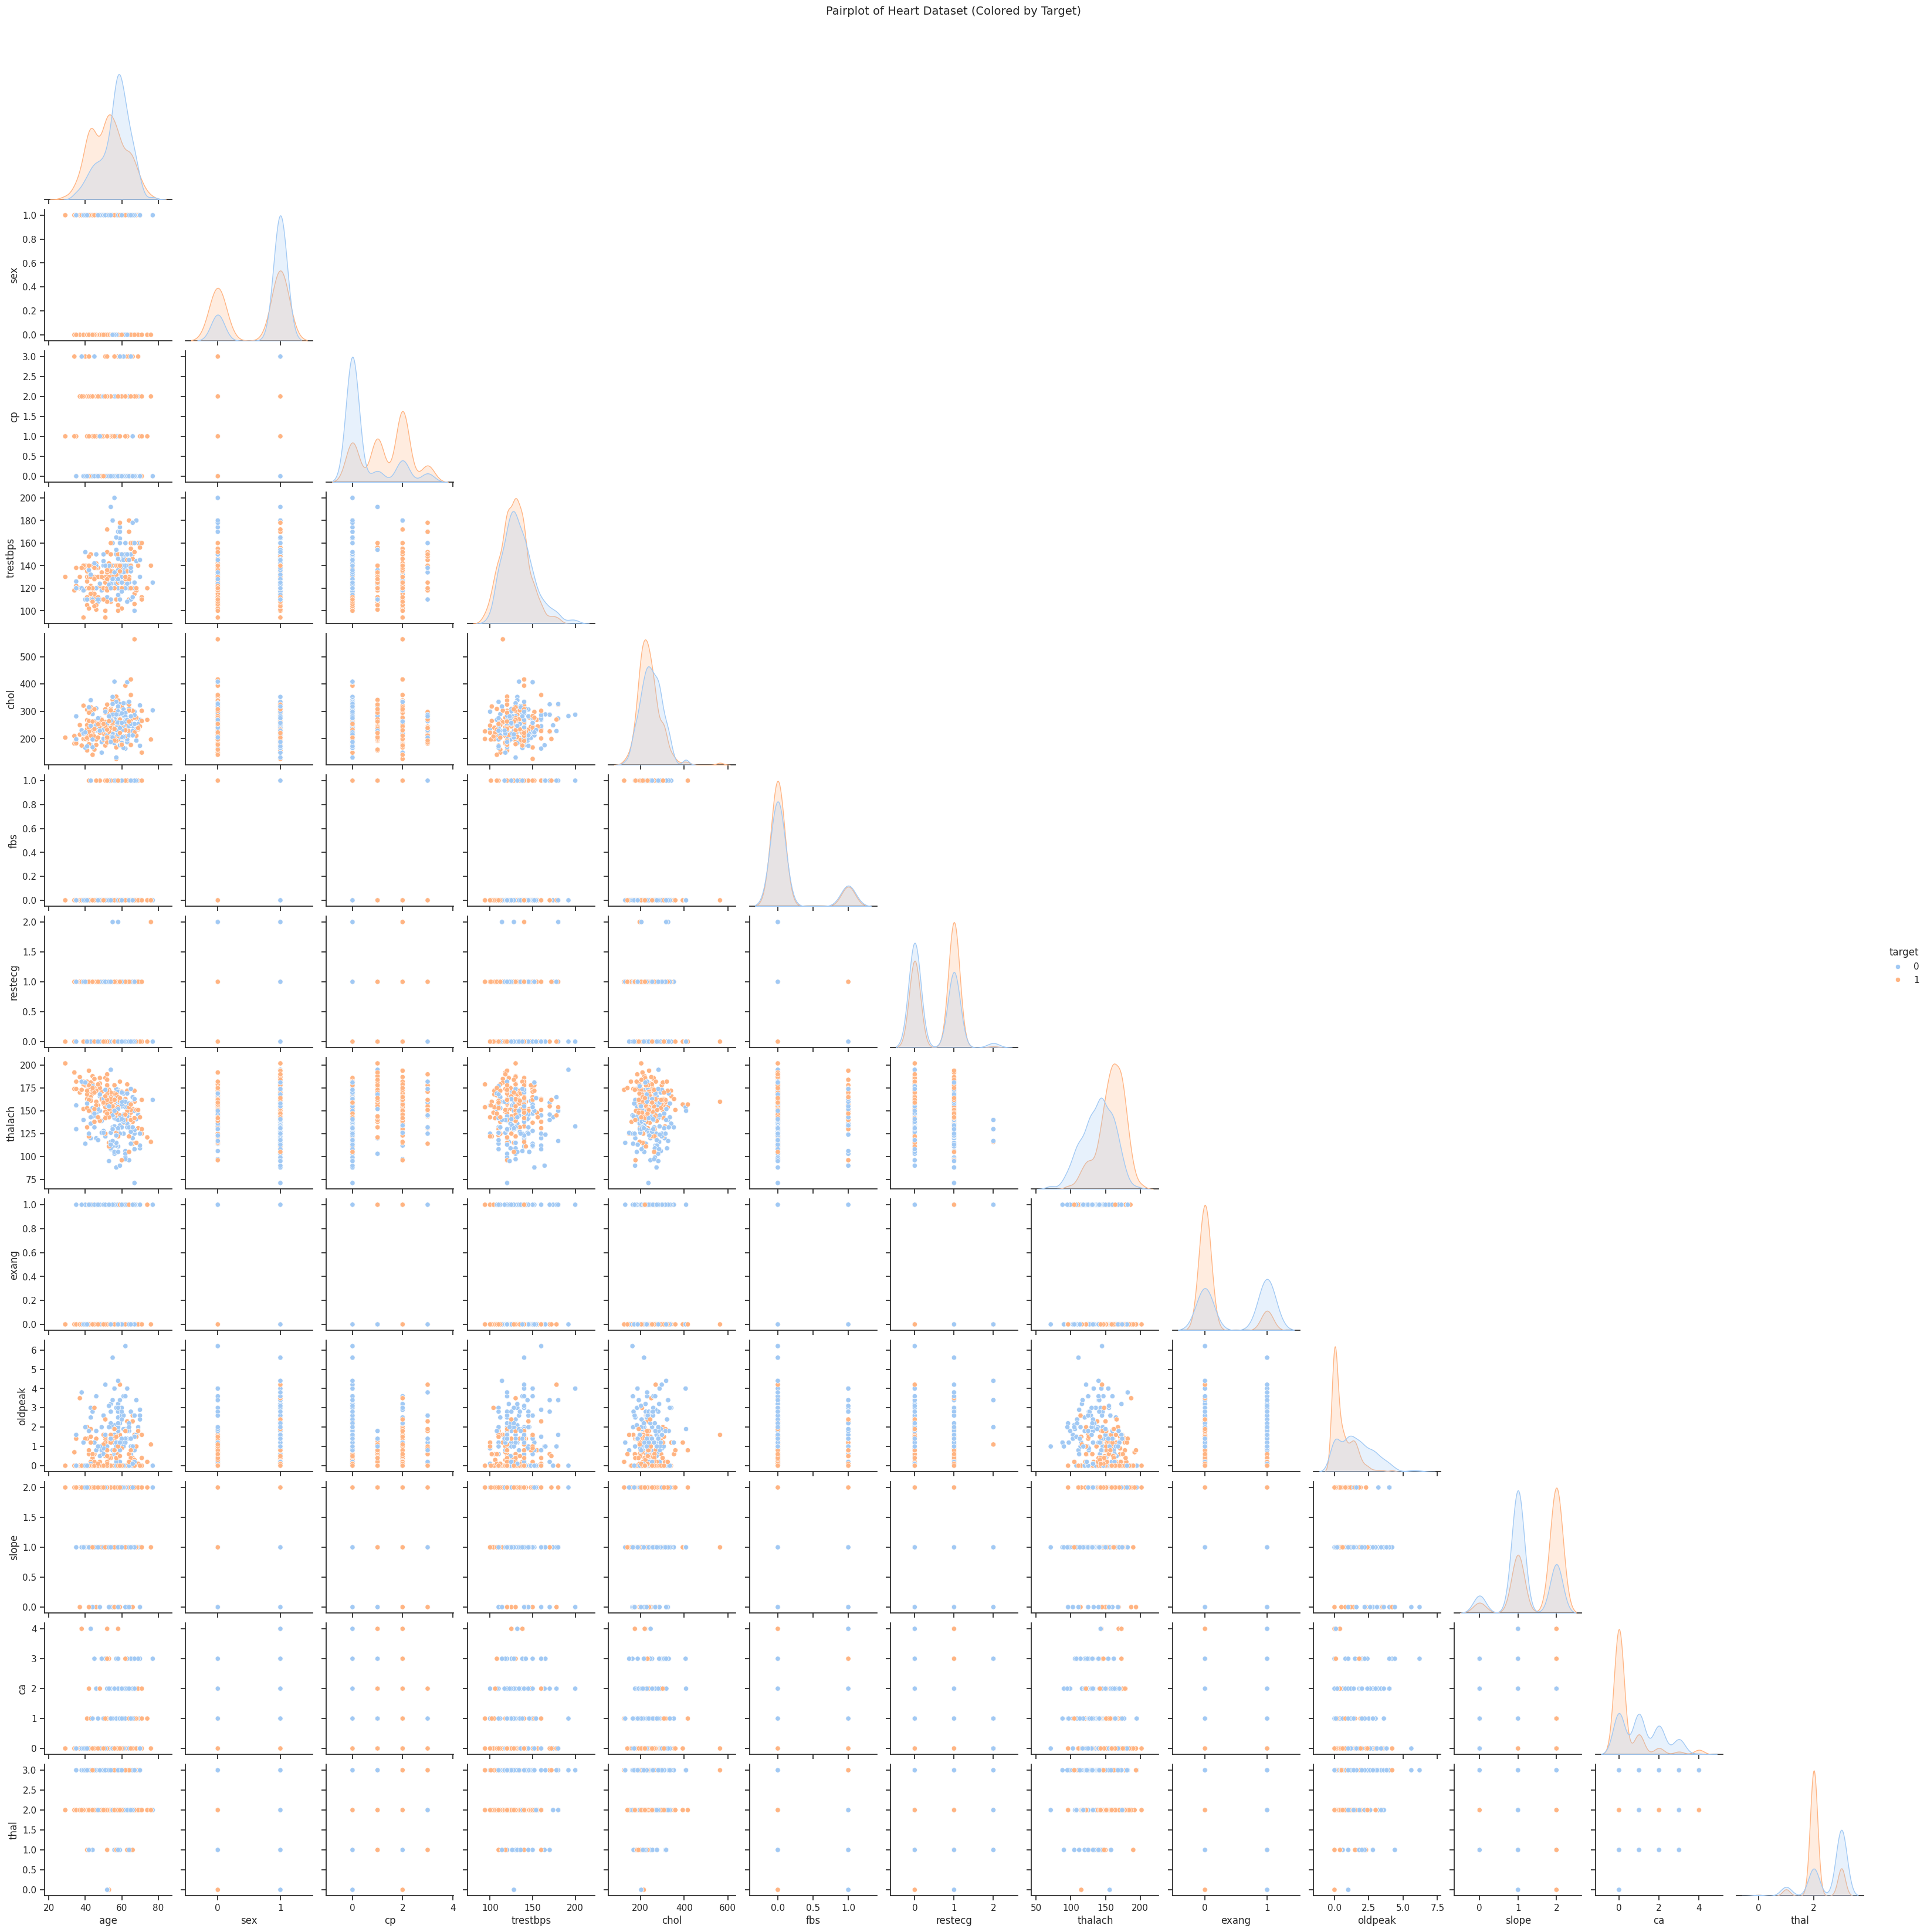

In [14]:
# Pairplot to visualize data distributions
sns.pairplot(df, hue='target', diag_kind='kde', corner=True)
plt.suptitle("Pairplot of Heart Dataset (Colored by Target)", y=1.02, fontsize=14)
plt.show()

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# region 2.3. Scaling numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

Training set shape: (717, 13)
Testing set shape: (308, 13)


In [16]:
# -----------------------------------------------------------------------------
# Training a CatBoostClassifier
# -----------------------------------------------------------------------------
# CatBoost handles categorical variables internally, but we've label-encoded them above for demonstration.
# We'll train a simple model with limited iterations for demonstration.
catboost_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    random_state=42
)
catboost_model.fit(X_train, y_train)

In [17]:
# -----------------------------------------------------------------------------
# Model Evaluation
# -----------------------------------------------------------------------------
y_pred = catboost_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       150
           1       1.00      0.98      0.99       158

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



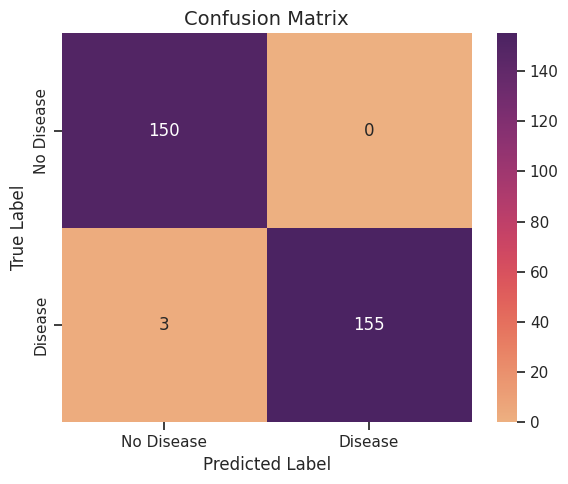

In [18]:
# -----------------------------------------------------------------------------
# Visualization: Confusion Matrix (flare colormap)
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="flare",
            xticklabels=["No Disease","Disease"],
            yticklabels=["No Disease","Disease"])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()


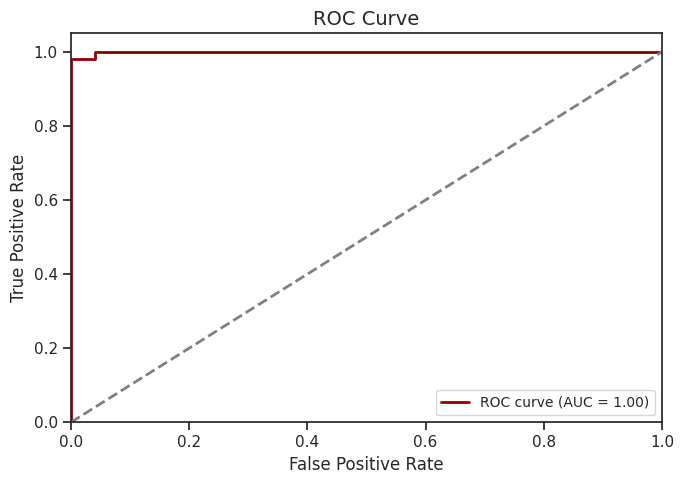

In [19]:
# -----------------------------------------------------------------------------
# Visualization: ROC Curve
# -----------------------------------------------------------------------------
# CatBoost's predict_proba gives probability of class 1
y_proba = catboost_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkred', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

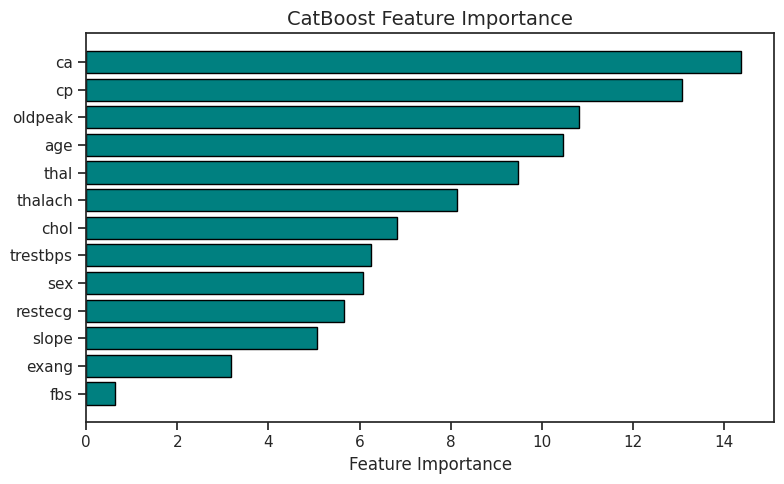

In [20]:
# -----------------------------------------------------------------------------
# Feature Importance using CatBoost
# -----------------------------------------------------------------------------
feature_importances = catboost_model.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[::-1]
features = X.columns

plt.figure(figsize=(8,5))
plt.barh([features[i] for i in sorted_idx],
         [feature_importances[i] for i in sorted_idx],
         color='teal', edgecolor='black')
plt.xlabel("Feature Importance", fontsize=12)
plt.title("CatBoost Feature Importance", fontsize=14)
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

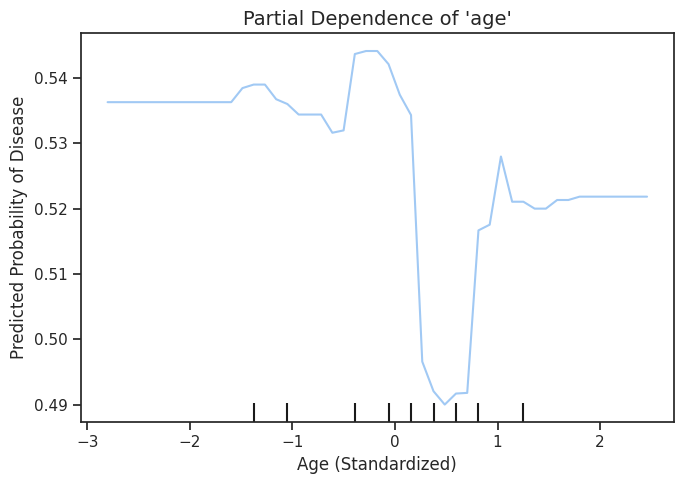

In [21]:
# -----------------------------------------------------------------------------
# Partial Dependence Plot
# -----------------------------------------------------------------------------
# We'll demonstrate partial dependence for 'age' if it exists in the dataset
if 'age' in X.columns:
    fig, ax = plt.subplots(figsize=(7,5))
    PartialDependenceDisplay.from_estimator(catboost_model,
                                            X_train,
                                            features=['age'],
                                            ax=ax)
    plt.title("Partial Dependence of 'age'", fontsize=14)
    plt.xlabel("Age (Standardized)", fontsize=12)
    plt.ylabel("Predicted Probability of Disease", fontsize=12)
    plt.tight_layout()
    plt.show()

In [22]:
# -----------------------------------------------------------------------------
# Final Observations
# -----------------------------------------------------------------------------
# This pipeline demonstrates:
# 1) Data loading, cleaning, encoding, and scaling for the Heart dataset.
# 2) Training a CatBoostClassifier for binary classification.
# 3) Multi-faceted evaluation: classification report, confusion matrix, ROC curve.
# 4) Feature importance from CatBoost plus partial dependence for interpretability.
# 5) Distinct visuals: "flare" colormap, partial dependence, pairplot for data exploration.
#
# Potential enhancements:
# - Hyperparameter tuning (e.g., more iterations, different depth)
# - Cross-validation for robust performance metrics
# - Cost-sensitive approach if missing diseased patients is especially costly
# - More advanced interpretability (SHAP, LIME)
# - Additional domain-specific feature engineering